In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor,RandomForestRegressor,GradientBoostingRegressor
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import train_test_split, LeaveOneOut, GridSearchCV
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge, Lasso
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score,explained_variance_score
import warnings  
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

# Data

## Power Consumption data

In [2]:
pjme_df = pd.read_csv('./Full_Data.csv', parse_dates=[0], index_col=[0])
pjme_df = pjme_df.loc[~pjme_df.index.duplicated(keep='first')].sort_index().dropna()
pjme_df.head()

,electric_power,EP_1_DAY_AGo,EP_1_Week_AGo,EP_4_Weeks_AGo,EP_Next_hour,electric_power_rolling_avg_one_day,electric_power_rolling_avg_one_week
tz,,,,,,,
2017-02-06 07:30:00,26.597063,0.0,0.0,0.0,30.096608,0.0,0.0
2017-02-06 08:30:00,30.096608,0.0,0.0,0.0,30.744339,0.0,0.0
2017-02-06 09:30:00,30.744339,0.0,0.0,0.0,30.696277,0.0,0.0
2017-02-06 10:30:00,30.696277,0.0,0.0,0.0,29.545297,0.0,0.0
2017-02-06 11:30:00,29.545297,0.0,0.0,0.0,29.500755,0.0,0.0


In [3]:
pjme_df.shape

(15153, 7)

In [4]:
pjme_df.describe()

,electric_power,EP_1_DAY_AGo,EP_1_Week_AGo,EP_4_Weeks_AGo,EP_Next_hour,electric_power_rolling_avg_one_day,electric_power_rolling_avg_one_week
count,15153.000000,15153.000000,15153.000000,15153.000000,15153.000000,15153.000000,15153.000000
mean,6.946251,6.932290,6.861642,6.619761,6.944495,4.893745,4.821543
std,5.760984,5.766693,5.803998,5.922748,5.759048,5.872368,5.885371
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.849544,6.844251,6.830669,6.781914,6.849378,6.652776,0.000000
75%,8.936326,8.926981,8.888963,8.798298,8.936110,7.895515,7.895515
max,36.533492,36.533492,36.533492,36.533492,36.533492,21.710769,21.710769


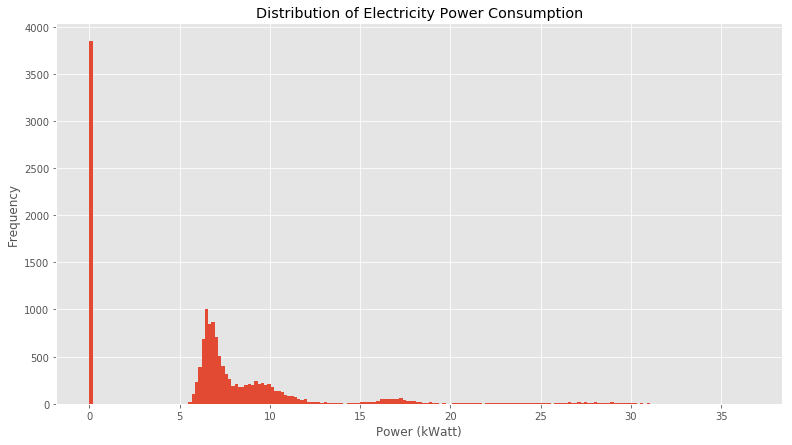

In [5]:
_ = pjme_df.electric_power.plot.hist(figsize=(13, 7), bins=200, title='Distribution of Electricity Power Consumption')
plt.xlabel('Power (kWatt)')
plt.show()

## Weather Data

### Combine Power and weather data

### Power and weather data visualization

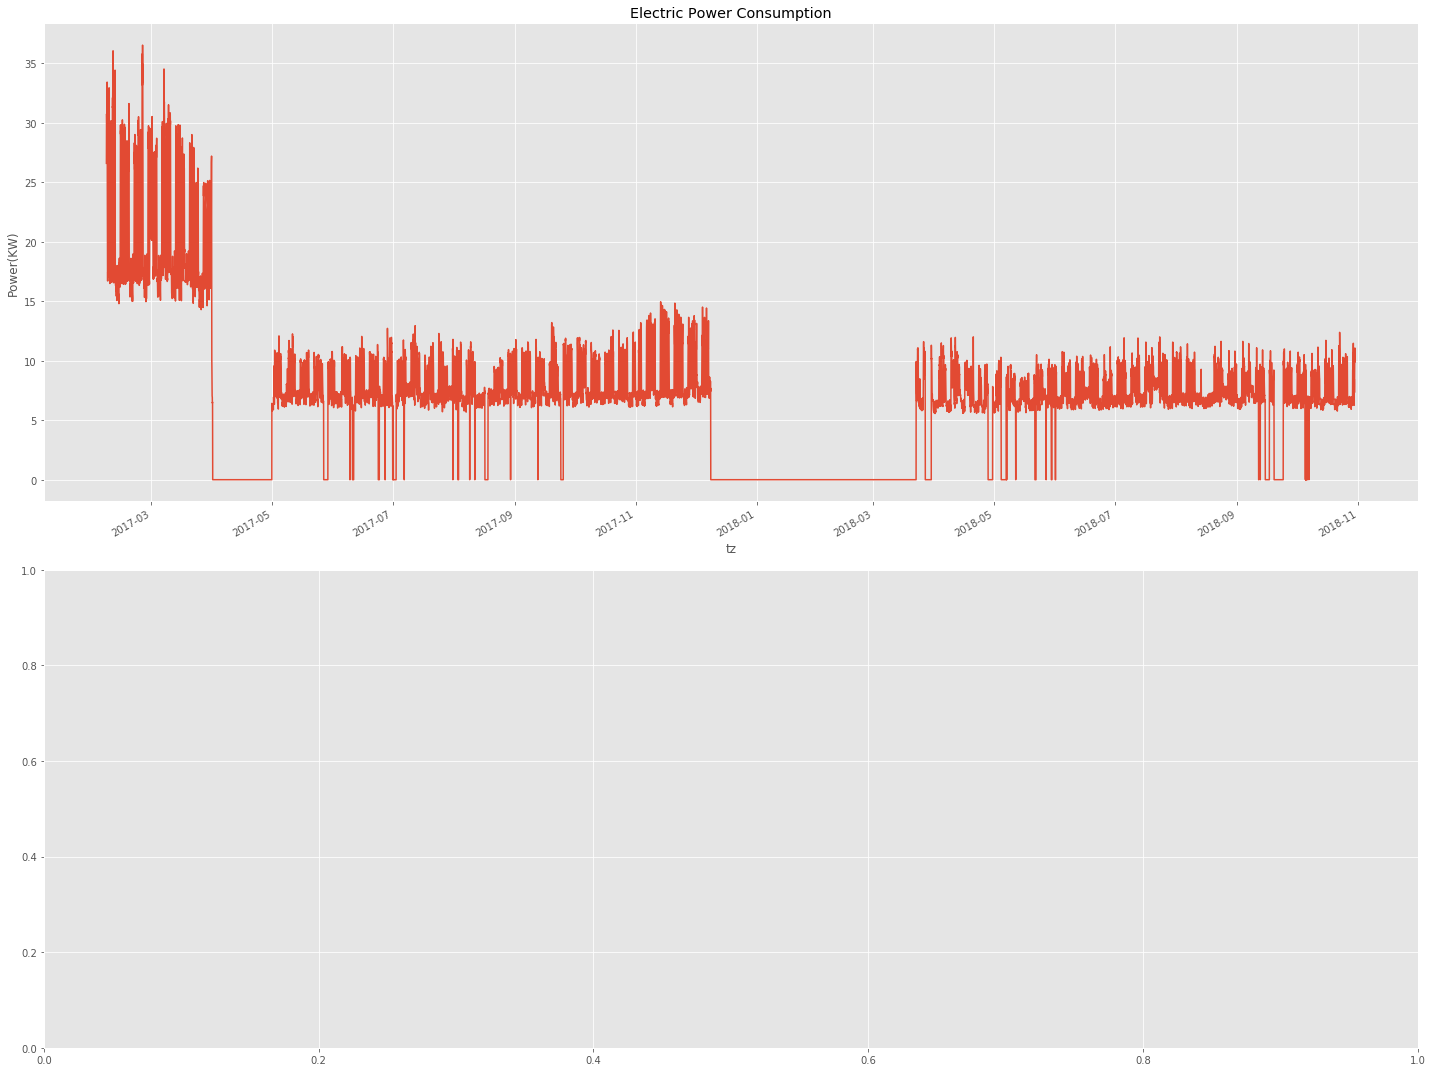

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,15))
axes[0].set_title('Electric Power Consumption')
axes[0].set_ylabel('Power(KW)')
axes[0].set_xlabel('Datetime')
pjme_df.electric_power.plot(ax=axes[0])




plt.tight_layout()
plt.show()

## Time series features

* Adding time series features.

In [7]:
pjme_df.head()

,electric_power,EP_1_DAY_AGo,EP_1_Week_AGo,EP_4_Weeks_AGo,EP_Next_hour,electric_power_rolling_avg_one_day,electric_power_rolling_avg_one_week
tz,,,,,,,
2017-02-06 07:30:00,26.597063,0.0,0.0,0.0,30.096608,0.0,0.0
2017-02-06 08:30:00,30.096608,0.0,0.0,0.0,30.744339,0.0,0.0
2017-02-06 09:30:00,30.744339,0.0,0.0,0.0,30.696277,0.0,0.0
2017-02-06 10:30:00,30.696277,0.0,0.0,0.0,29.545297,0.0,0.0
2017-02-06 11:30:00,29.545297,0.0,0.0,0.0,29.500755,0.0,0.0


## Features correlation heatmap

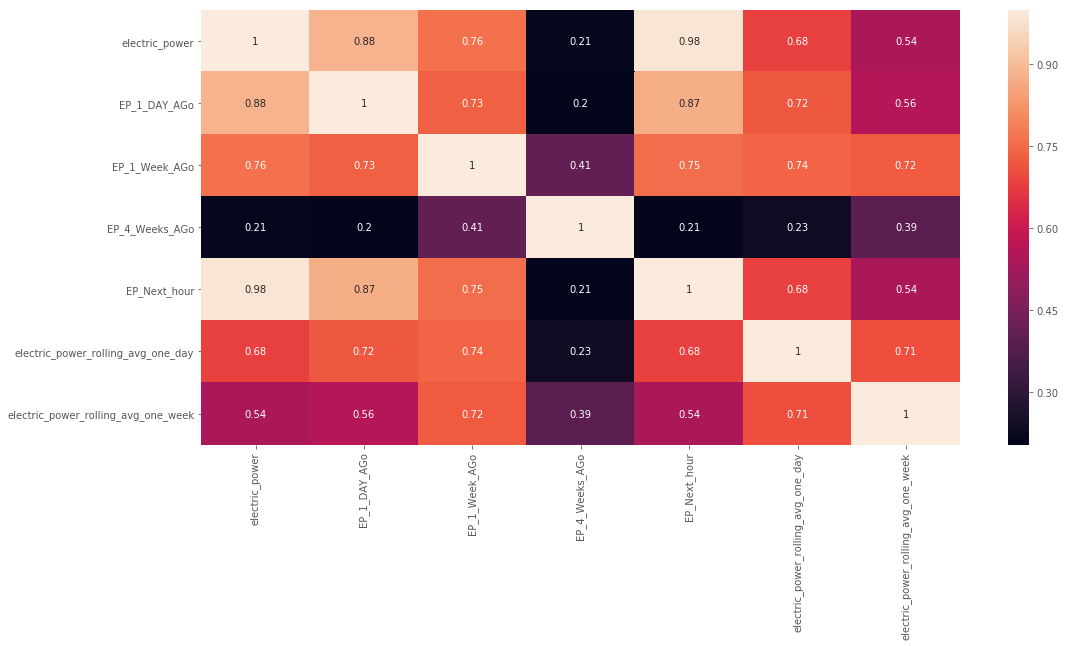

In [8]:
fig, ax = plt.subplots(figsize = (17,8))
corr = pjme_df.corr()
ax = sns.heatmap(corr, annot=True,
            xticklabels = corr.columns.values,
            yticklabels = corr.columns.values)
plt.show()

* **Power consumption** is highly correlated to the **hour**.

## Regression Models

## Lagging features


In [9]:

# Build lagged weather predictors.
# lagged_df = comb_df.loc[comb_df.index.min().ceil('D'):].copy()
lagged_df = pjme_df.copy()

# Next day's load values.
lagged_df['load_tomorrow'] = lagged_df['electric_power'].shift(-24)    

for day in range(8):
    lagged_df['EP_1_DAY_AGo_d' + str(day)] = lagged_df.EP_1_DAY_AGo.shift(24*day)
    lagged_df['EP_1_Week_AGo_d' + str(day)] = lagged_df.EP_1_Week_AGo.shift(24*day)
    lagged_df['EP_4_Weeks_AGo' + str(day)] = lagged_df.EP_4_Weeks_AGo.shift(24*day)
    lagged_df['EP_Next_hour_d' + str(day)] = lagged_df.EP_Next_hour.shift(24*day)
    lagged_df['electric_power_rolling_avg_one_day_d' + str(day)] = lagged_df.electric_power_rolling_avg_one_day.shift(24*day)
    lagged_df['electric_power_rolling_avg_one_week_d' + str(day)] = lagged_df.electric_power_rolling_avg_one_week.shift(24*day)
    lagged_df['load_d' + str(day)] = lagged_df.electric_power.shift(24*day)
   
    


     
lagged_df = lagged_df.dropna()
    

lagged_df = lagged_df.drop(columns=['EP_1_DAY_AGo','EP_1_Week_AGo','EP_4_Weeks_AGo','EP_Next_hour','electric_power_rolling_avg_one_day','electric_power_rolling_avg_one_week','electric_power'])
# lagged_df.iloc[50:80]



In [10]:
lagged_df.tail(5)

,load_tomorrow,EP_1_DAY_AGo_d0,EP_1_Week_AGo_d0,EP_4_Weeks_AGo0,EP_Next_hour_d0,electric_power_rolling_avg_one_day_d0,electric_power_rolling_avg_one_week_d0,load_d0,EP_1_DAY_AGo_d1,EP_1_Week_AGo_d1,...,electric_power_rolling_avg_one_day_d6,electric_power_rolling_avg_one_week_d6,load_d6,EP_1_DAY_AGo_d7,EP_1_Week_AGo_d7,EP_4_Weeks_AGo7,EP_Next_hour_d7,electric_power_rolling_avg_one_day_d7,electric_power_rolling_avg_one_week_d7,load_d7
tz,,,,,,,,,,,,,,,,,,,,,
2018-10-29 11:30:00,11.071924,6.113942,10.791823,9.087273,8.772211,7.653226,7.557639,8.525509,6.262288,5.905070,...,7.557639,7.427220,9.698699,5.905070,10.173165,10.702522,10.874629,7.523524,7.396724,10.791823
2018-10-29 12:30:00,10.741479,6.015793,10.874629,9.812068,9.484859,7.654179,7.565045,8.772211,6.091587,5.855681,...,7.565045,7.427773,9.538340,5.855681,9.630437,10.279495,11.223755,7.522900,7.400893,10.874629
2018-10-29 13:30:00,10.163620,6.002803,11.223755,9.676648,9.654269,7.654877,7.575087,9.484859,6.178693,5.885505,...,7.575087,7.433859,8.993180,5.885505,9.536622,10.236461,10.997043,7.522353,7.405350,11.223755
2018-10-29 14:30:00,9.992667,5.920353,10.997043,9.953229,10.016429,7.655783,7.584094,9.654269,6.116038,5.768235,...,7.584094,7.439860,8.663304,5.768235,9.483979,10.221975,10.368045,7.521195,7.408955,10.997043
2018-10-29 15:30:00,9.924275,6.024754,10.368045,9.684885,11.468788,7.655820,7.588294,10.016429,6.127198,6.018489,...,7.588294,7.445980,8.668408,6.018489,9.662386,9.505391,8.004700,7.520777,7.415218,10.368045


In [11]:
X = lagged_df.drop(columns=['load_tomorrow'])
y = lagged_df['load_tomorrow']

In [12]:
X.shape

(14961, 56)

In [13]:
y.shape

(14961,)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [15]:
def plot_prediction(actual, prediction, start_date, end_date, title, prediction_label):
    plt.figure(figsize=(20,5))
    plt.title(title)
    plt.plot(y_test.index, y_test, label='Actual')
    plt.plot(y_test.index, prediction, label=prediction_label)
    plt.ylabel('Power(KW)')
    plt.xlabel('Datetime')
    plt.legend()
    plt.xlim(left= start_date, right=end_date)
    plt.show()
    
def subplot_prediction(actual, prediction,prediction_label):
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 15))
    
    con_df = pd.concat([actual.rename('Actual'),pd.DataFrame(prediction, index=actual.index, columns=[prediction_label])], axis=1)
    axes[0].set_title('Actual vs Prediction - One day')
    axes[0].set_ylabel('Power(KW)')
    axes[0].set_xlabel('Datetime')
    con_df.plot(ax=axes[0])
    axes[0].set_xlim(left=con_df.index[-24*1] , right=con_df.index[-1])
    
    axes[1].set_title('Actual vs Prediction - One week')
    axes[1].set_ylabel('Power(KW)')
    axes[1].set_xlabel('Datetime')
    con_df.plot(ax=axes[1])
    axes[1].set_xlim(left=actual.index[-24*7] , right=actual.index[-1])
    
    axes[2].set_title('Actual vs Prediction - One month')
    axes[2].set_ylabel('Power(KW)')
    axes[2].set_xlabel('Datetime')
    con_df.plot(ax=axes[2])
    axes[2].set_xlim(left=actual.index[-24*7*4] , right=actual.index[-1])
    
    plt.tight_layout()
    plt.show()
    
def plot_feature_importances( clf, X_train, y_train=None
                             ,top_n=10, figsize=(10,18), print_table=False, title="Feature Importances"):
    feat_imp = pd.DataFrame({'importance':clf.feature_importances_})    
    feat_imp['feature'] = X_train.columns
    feat_imp.sort_values(by='importance', ascending=False, inplace=True)
    feat_imp = feat_imp.iloc[:top_n]
    
    feat_imp.sort_values(by='importance', inplace=True)
    feat_imp = feat_imp.set_index('feature', drop=True)
    feat_imp.plot.barh(title=title, figsize=figsize)
    plt.xlabel('Feature Importance Score')
    plt.show()
    
    if print_table:
        from IPython.display import display
        print("Top {} features in descending order of importance".format(top_n))
        display(feat_imp.sort_values(by='importance', ascending=False))
        
    return feat_imp


In [16]:
reg = xgb.XGBRegressor()

In [17]:
tscv = TimeSeriesSplit(n_splits=2)
scores = cross_val_score(reg, X.values, y.values, cv=tscv
                         ,scoring='explained_variance'
                        )
print("Accuracy: %0.2f " % (scores.mean()*100))
print(scores)
reg.fit(X_train,y_train)
prediction = reg.predict(X_test)
print("R2 Score :%0.2f "% r2_score(y_test,prediction))
print(r2_score)

[22:59:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:59:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Accuracy: 44.30 
[0.43800984 0.44807993]
[22:59:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R2 Score :0.45 
<function r2_score at 0x000001C530118A60>


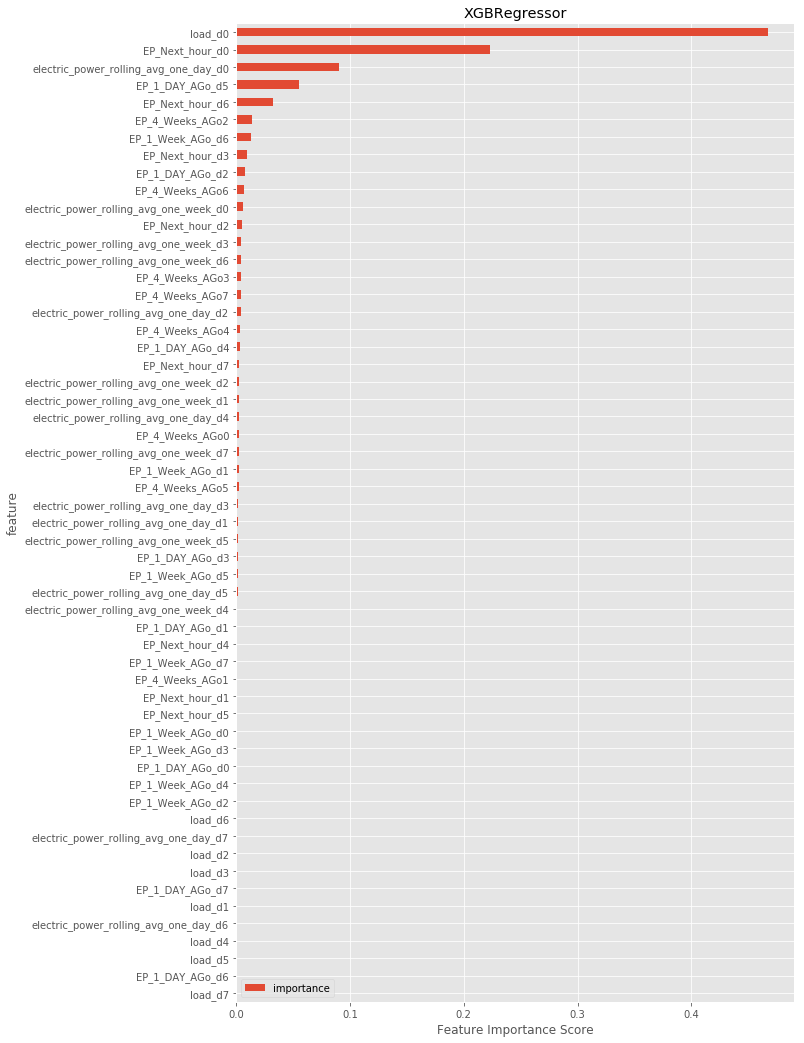

Top 56 features in descending order of importance


,importance
feature,
load_d0,0.466866
EP_Next_hour_d0,0.223331
electric_power_rolling_avg_one_day_d0,0.090584
EP_1_DAY_AGo_d5,0.055527
EP_Next_hour_d6,0.032227
EP_4_Weeks_AGo2,0.014074
EP_1_Week_AGo_d6,0.013115
EP_Next_hour_d3,0.009407
EP_1_DAY_AGo_d2,0.007991


In [18]:
_ = plot_feature_importances(reg, X_train, y_train, top_n=X_train.shape[1], title=reg.__class__.__name__, print_table=True)


In [19]:
pjme_df.head()

,electric_power,EP_1_DAY_AGo,EP_1_Week_AGo,EP_4_Weeks_AGo,EP_Next_hour,electric_power_rolling_avg_one_day,electric_power_rolling_avg_one_week
tz,,,,,,,
2017-02-06 07:30:00,26.597063,0.0,0.0,0.0,30.096608,0.0,0.0
2017-02-06 08:30:00,30.096608,0.0,0.0,0.0,30.744339,0.0,0.0
2017-02-06 09:30:00,30.744339,0.0,0.0,0.0,30.696277,0.0,0.0
2017-02-06 10:30:00,30.696277,0.0,0.0,0.0,29.545297,0.0,0.0
2017-02-06 11:30:00,29.545297,0.0,0.0,0.0,29.500755,0.0,0.0


In [20]:
def get_features(date, pjme_df):
    features = pjme_df.loc[date]
    features = (features.assign(
                                day_of_week = features.index.dayofweek
                                ,year = features.index.year
                                ,month = features.index.month
                                ,day = features.index.day
                                ,day_of_year = features.index.dayofyear
                                ,week = features.index.week
                                ,week_day = features.index.weekday_name 
                                ,quarter = features.index.quarter
                                ,hour = features.index.hour
                                ,hour_x = np.sin(2.*np.pi*features.index.hour/24.)
                                ,hour_y = np.cos(2*np.pi*features.index.hour/24.)
                                ,day_of_year_x = np.sin(2.*np.pi*features.index.dayofyear/365.)
                                ,day_of_year_y = np.cos(2.*np.pi*features.index.dayofyear/365.)
                                
                                ))
    
    for day in range(8):
         features['EP_1_DAY_AGo_d' + str(day)] = features.EP_1_DAY_AGo.shift(24*day)
    features['EP_1_Week_AGo_d' + str(day)] = features.EP_1_Week_AGo.shift(24*day)
    features['EP_4_Weeks_AGo' + str(day)] = features.EP_4_Weeks_AGo.shift(24*day)
    features['EP_Next_hour_d' + str(day)] = features.EP_Next_hour.shift(24*day)
    features['electric_power_rolling_avg_one_day_d' + str(day)] = features.electric_power_rolling_avg_one_day.shift(24*day)
    features['electric_power_rolling_avg_one_week_d' + str(day)] = features.electric_power_rolling_avg_one_week.shift(24*day)
    features['load_d' + str(day)] = features.electric_power.shift(24*day)
   
    features = features.dropna()
    
    features = features.drop(columns=['EP_1_DAY_AGo','EP_1_Week_AGo','EP_4_Weeks_AGo','EP_Next_hour','electric_power_rolling_avg_one_day','electric_power_rolling_avg_one_week','electric_power'])

    return features





# Regression Models

In [21]:
X = pjme_df.drop(columns = ['electric_power'])
y = pjme_df['electric_power']

In [22]:
X.shape

(15153, 6)

In [23]:
y.shape

(15153,)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

## XGB Model


In [25]:
reg = xgb.XGBRegressor()

In [27]:
tscv = TimeSeriesSplit(n_splits=50)
scores = cross_val_score(reg, X.values, y.values, cv=tscv
                         ,scoring='explained_variance'
                        )
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() ))
print(scores)

[23:00:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:00:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:00:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:00:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:00:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:00:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:00:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:00:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:00:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [28]:
print("Accuracy: %0.2f " % (scores.mean()*100))
print(scores)
reg.fit(X_train,y_train)
prediction = reg.predict(X_test)
print("R2 Score :%0.2f "% r2_score(y_test,prediction))
print(r2_score)

Accuracy: 77.54 
[0.90218282 0.93282178 0.852053   0.27196923 0.         0.5218875
 0.79454457 0.96166543 0.72539919 0.90557467 0.86654468 0.83108059
 0.88999119 0.61775212 0.81689602 0.67618824 0.70991542 0.9183177
 0.92086948 0.92268991 0.86636634 0.8441773  0.88474416 0.96617615
 0.         0.         1.         1.         1.         1.
 1.         1.         0.88998626 0.8648768  0.76569458 0.89965865
 0.76967546 0.66974567 0.82309338 0.80580151 0.82069    0.81052137
 0.86587629 0.771388   0.71215777 0.81543889 0.90771362 0.66665375
 0.58047048 0.73132669]
[23:01:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R2 Score :0.86 
<function r2_score at 0x000001C530118A60>


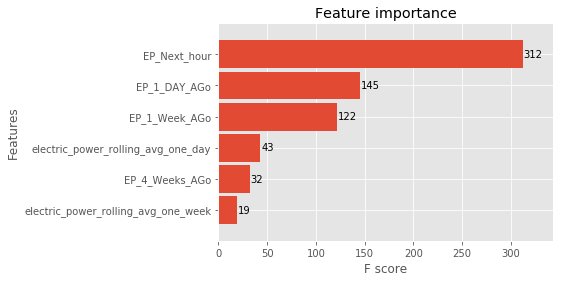

In [29]:
_ = plot_importance(reg, height=0.9)

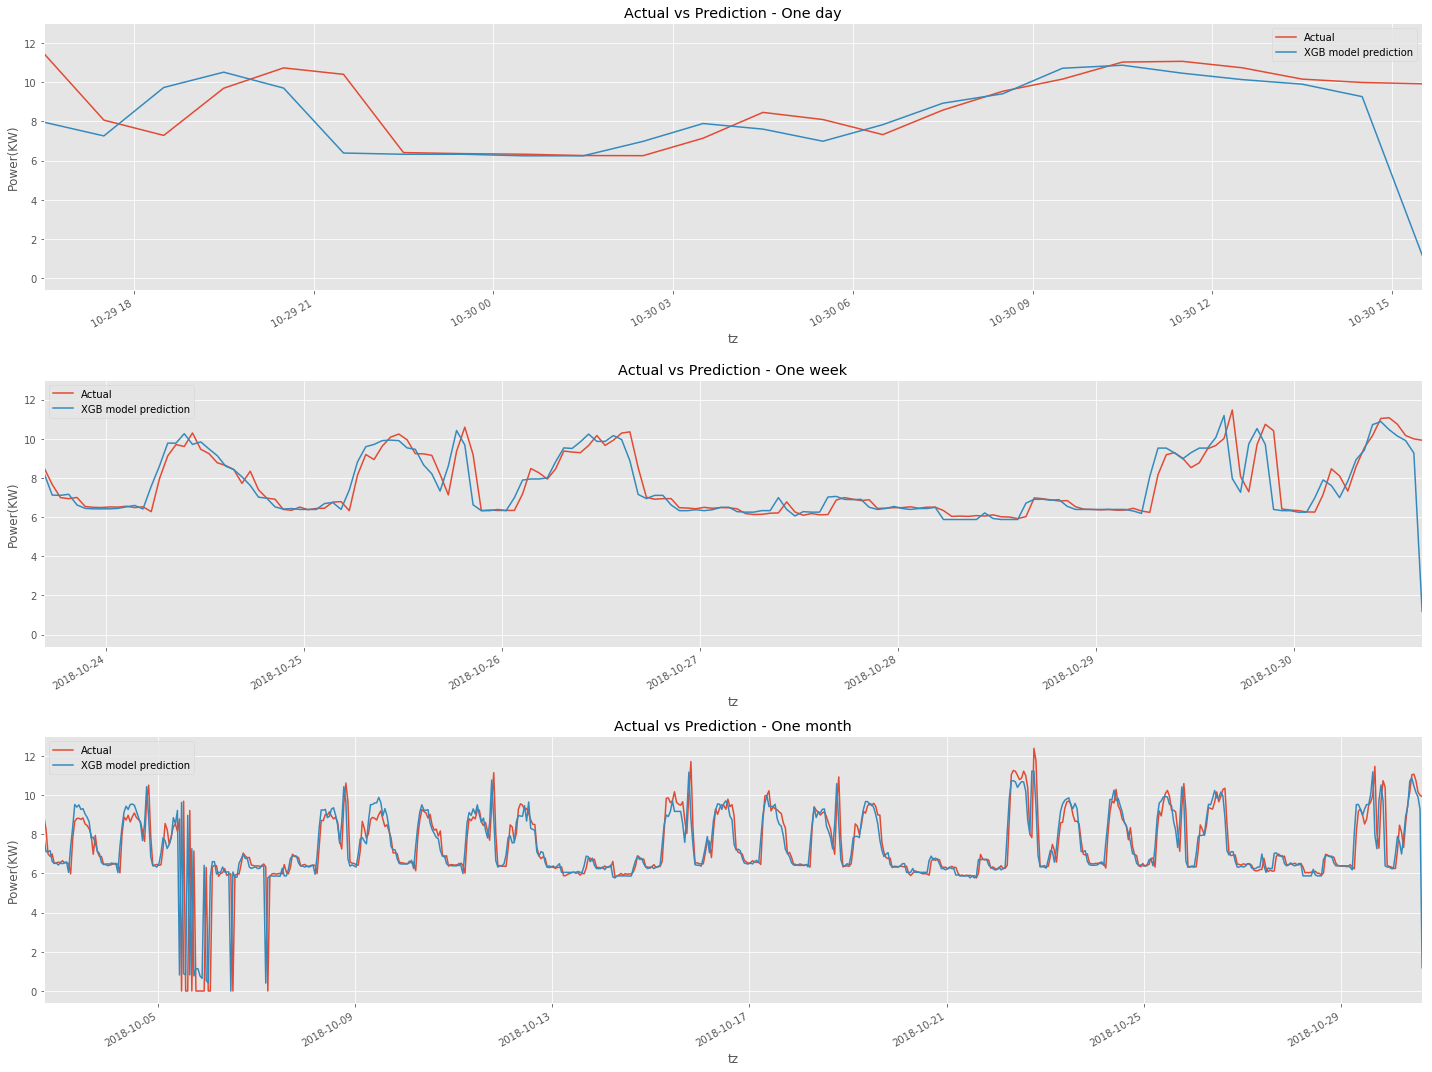

In [30]:
subplot_prediction(y_test, prediction,prediction_label='XGB model prediction')

# AdaBoost Model

In [31]:
reg = AdaBoostRegressor()

In [32]:
tscv = TimeSeriesSplit(n_splits=20)
scores = cross_val_score(reg, X.values, y.values, cv=tscv
                         ,scoring='explained_variance'
                        )
print("Accuracy: %0.2f " % (scores.mean()*100))
print(scores)
reg.fit(X_train,y_train)
prediction = reg.predict(X_test)
print("R2 Score :%0.2f "% r2_score(y_test,prediction))
print(r2_score)

Accuracy: 47.66 
[0.31660045 0.3856232  0.72326018 0.74372519 0.53754701 0.44232279
 0.55183738 0.60775345 0.62910337 0.94127861 0.         1.
 0.50596866 0.5909952  0.52999775 0.03511373 0.1183431  0.0721687
 0.63154498 0.16979456]
R2 Score :0.24 
<function r2_score at 0x000001C530118A60>


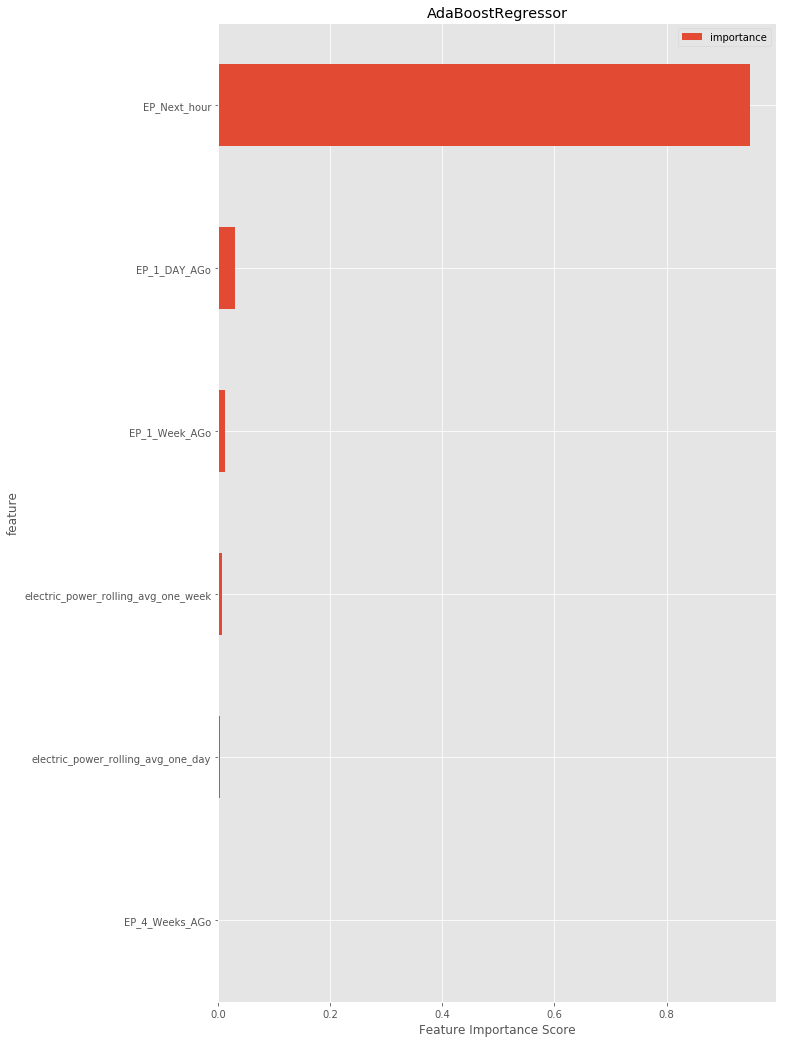

In [33]:
_ = plot_feature_importances(reg, X_train, y_train, top_n=X_train.shape[1], title=reg.__class__.__name__)

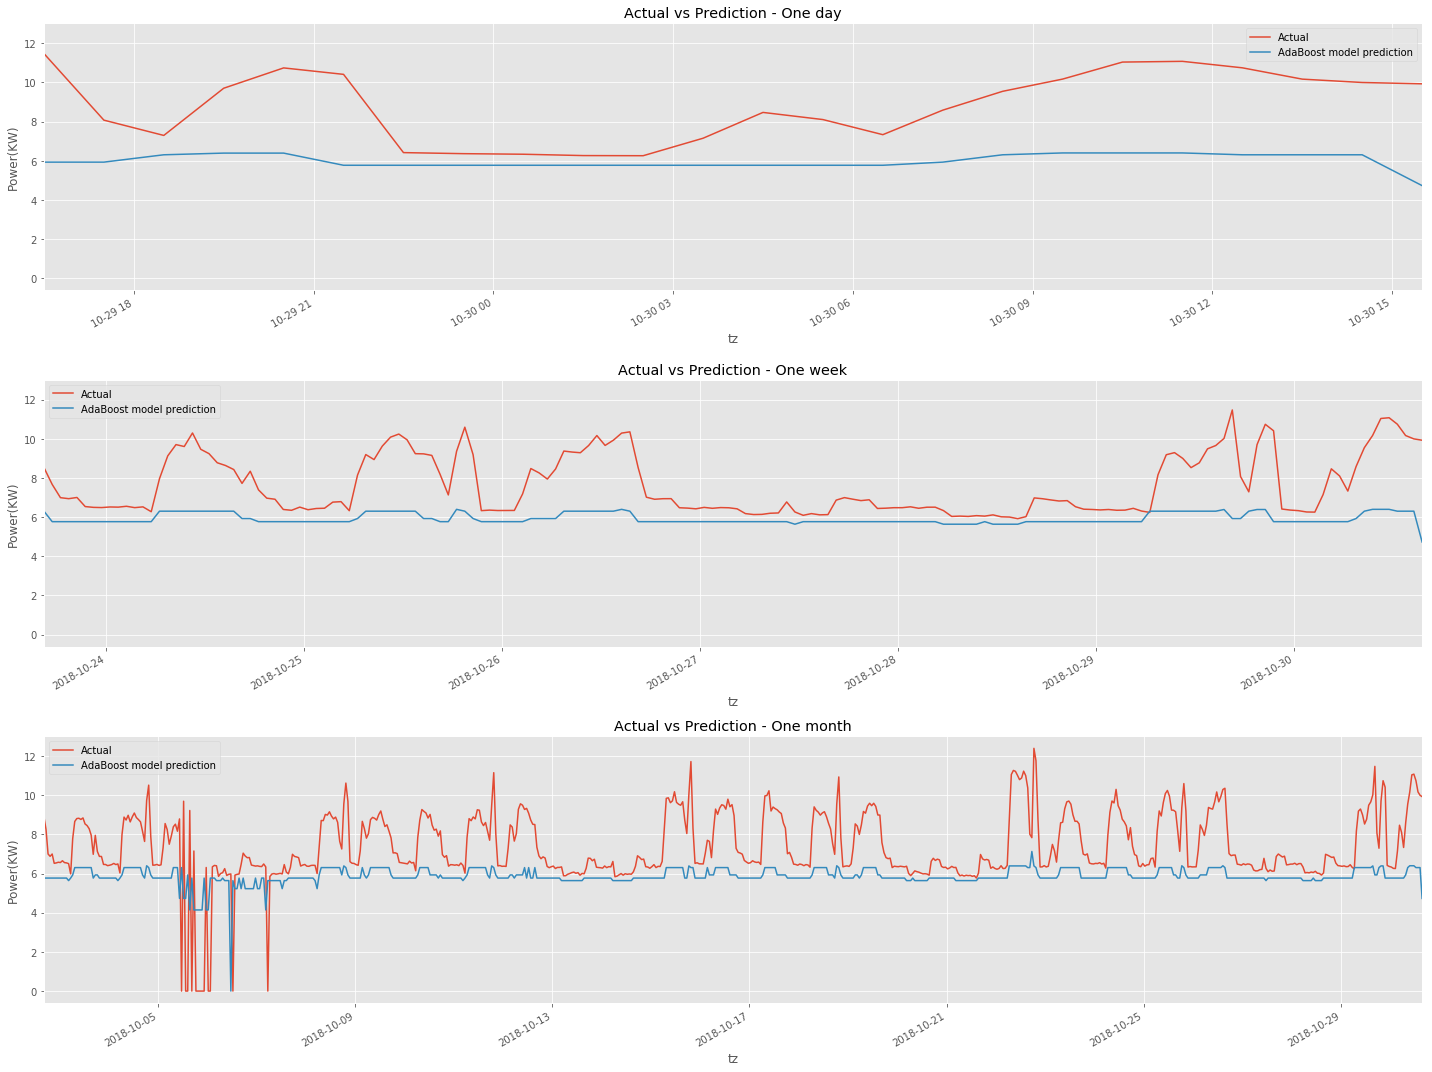

In [34]:
subplot_prediction(y_test, prediction,prediction_label='AdaBoost model prediction')

# Bagging Regressor Model

In [35]:
reg = BaggingRegressor()

In [36]:
tscv = TimeSeriesSplit(n_splits=20)
scores = cross_val_score(reg, X.values, y.values, cv=tscv
                         ,scoring='explained_variance'
                        )
print("Accuracy: %0.2f " % (scores.mean()*100))
print(scores)
reg.fit(X_train,y_train)
prediction = reg.predict(X_test)
print("R2 Score :%0.2f "% r2_score(y_test,prediction))
print(r2_score)

Accuracy: 81.01 
[0.37803361 0.6643907  0.91672554 0.80893055 0.756561   0.73043639
 0.83585429 0.89831028 0.85837505 0.9587826  1.         1.
 0.93736994 0.89751747 0.78285986 0.81217134 0.82821421 0.66062409
 0.90628425 0.57038287]
R2 Score :0.84 
<function r2_score at 0x000001C530118A60>


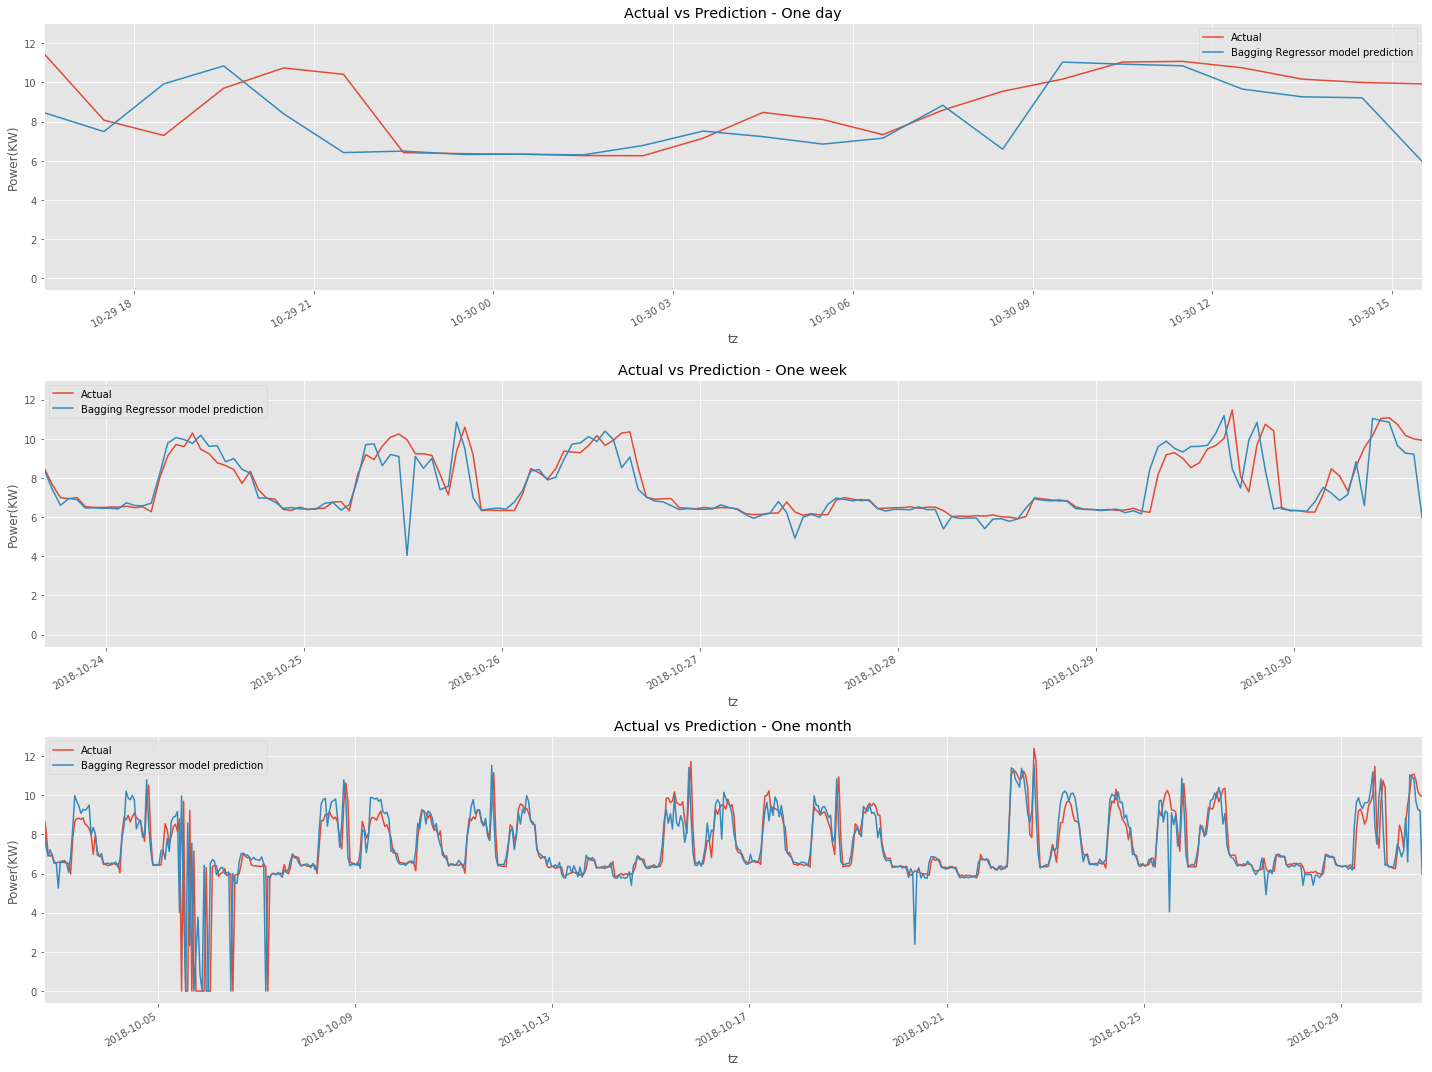

In [37]:
subplot_prediction(y_test, prediction,prediction_label='Bagging Regressor model prediction')

# Extra Trees Regressosr Model

In [38]:
reg = ExtraTreesRegressor()

In [39]:
tscv = TimeSeriesSplit(n_splits=20)
scores = cross_val_score(reg, X.values, y.values, cv=tscv
                         ,scoring='explained_variance'
                        )
print("Accuracy: %0.2f " % (scores.mean()*100))
print(scores)
reg.fit(X_train,y_train)
prediction = reg.predict(X_test)
print("R2 Score :%0.2f "% r2_score(y_test,prediction))
print(r2_score)

Accuracy: 82.37 
[0.38826177 0.96341341 0.877224   0.83166453 0.74062511 0.75338208
 0.86064169 0.90069373 0.85019111 0.92956861 1.         1.
 0.94818422 0.86568979 0.79804425 0.7946936  0.86222123 0.60021535
 0.91350407 0.59489564]
R2 Score :0.84 
<function r2_score at 0x000001C530118A60>


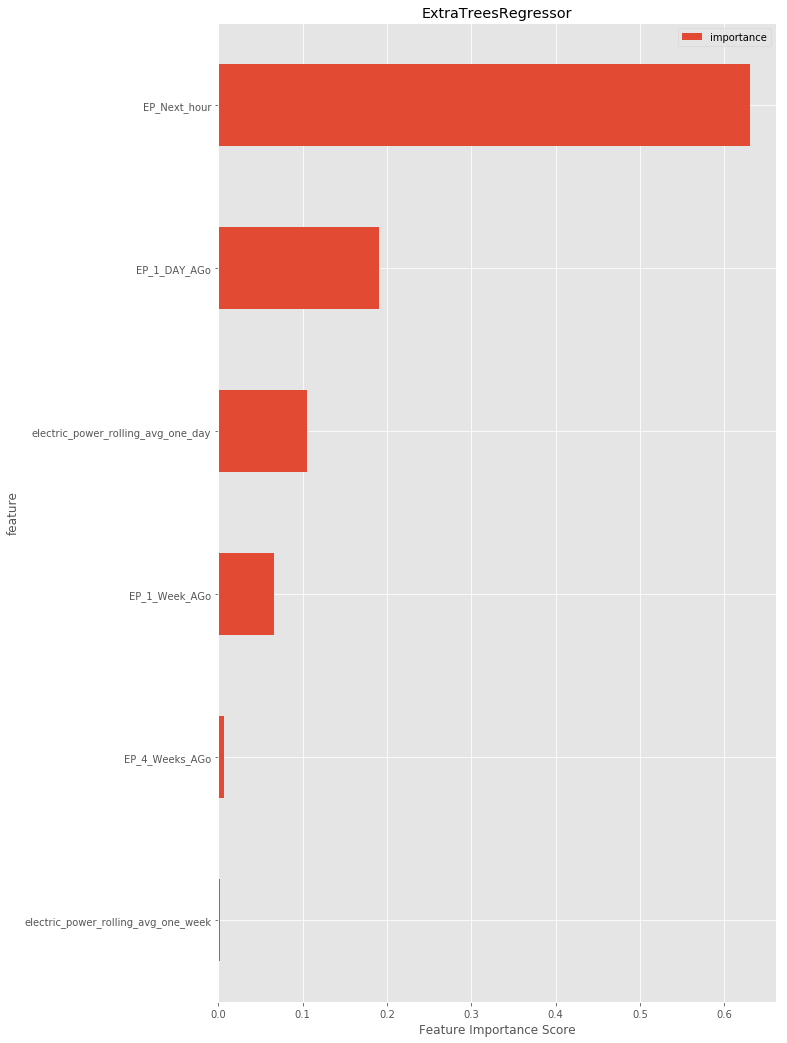

In [40]:
_ = plot_feature_importances(reg, X_train, y_train, top_n=X_train.shape[1], title=reg.__class__.__name__)

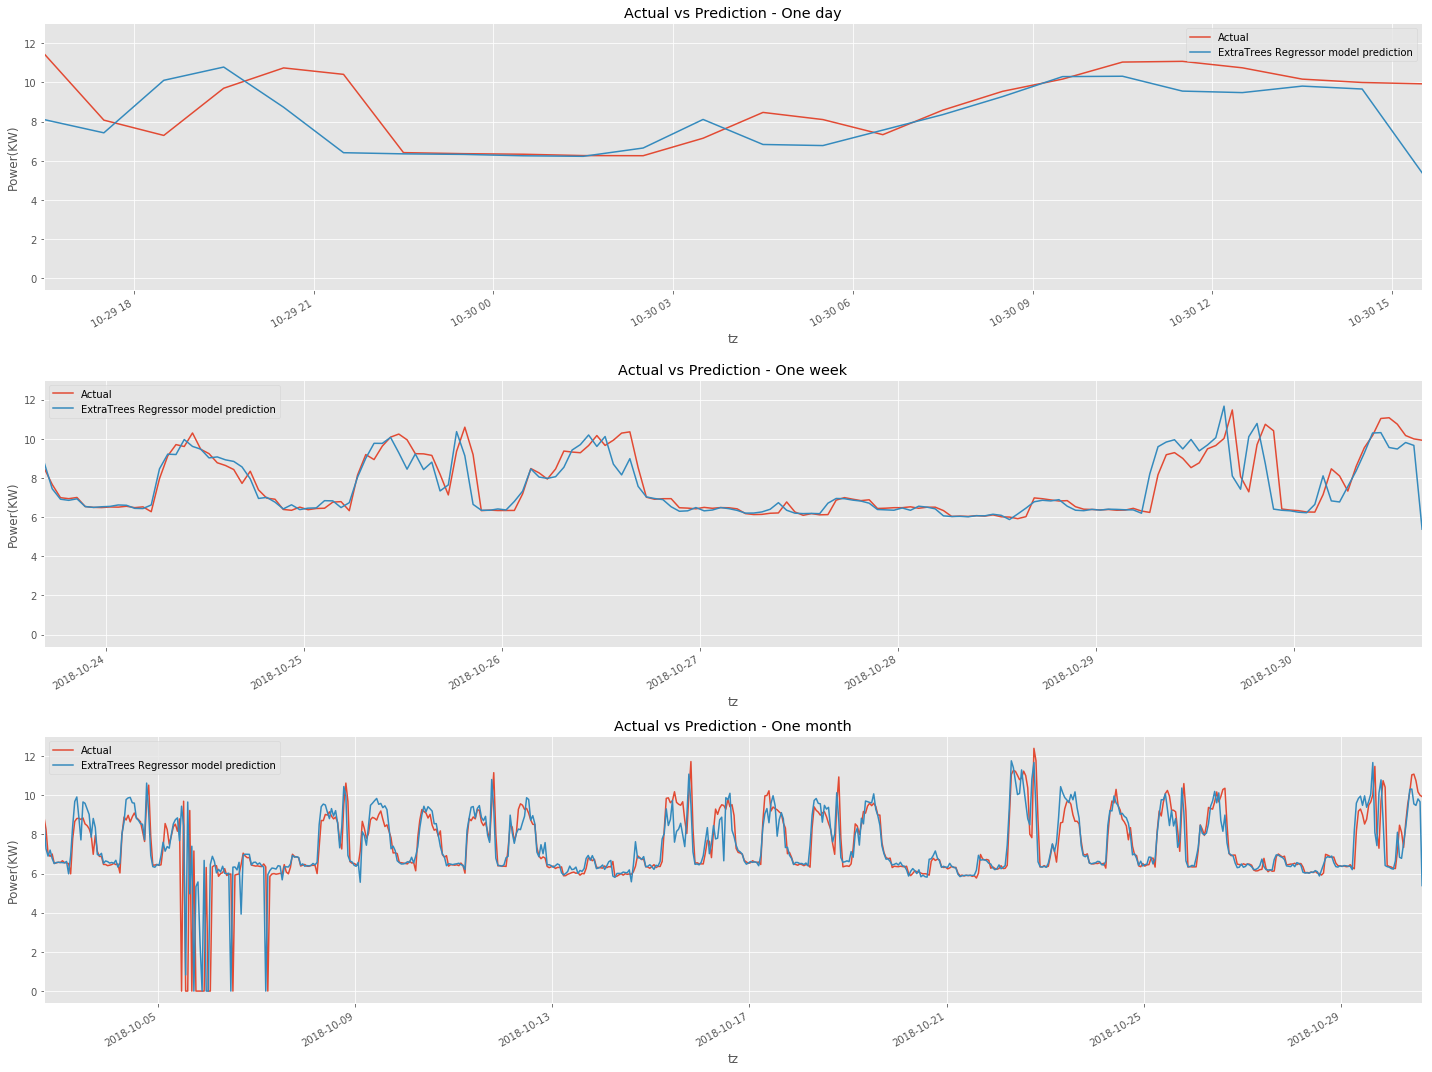

In [41]:
subplot_prediction(y_test, prediction,prediction_label='ExtraTrees Regressor model prediction')

In [42]:
reg = RandomForestRegressor()

In [43]:
tscv = TimeSeriesSplit(n_splits=20)
scores = cross_val_score(reg, X.values, y.values, cv=tscv
                         ,scoring='explained_variance'
                        )
print("Accuracy: %0.2f " % (scores.mean()*100))
print(scores)
reg.fit(X_train,y_train)
prediction = reg.predict(X_test)
print("R2 Score :%0.2f "% r2_score(y_test,prediction))
print(r2_score)

Accuracy: 80.51 
[0.39857603 0.55089193 0.91409097 0.80300241 0.77066689 0.68720763
 0.87145521 0.90116003 0.83902339 0.94519027 1.         1.
 0.93318893 0.8947269  0.79996397 0.80180075 0.82086625 0.67502866
 0.91505984 0.58097494]
R2 Score :0.85 
<function r2_score at 0x000001C530118A60>


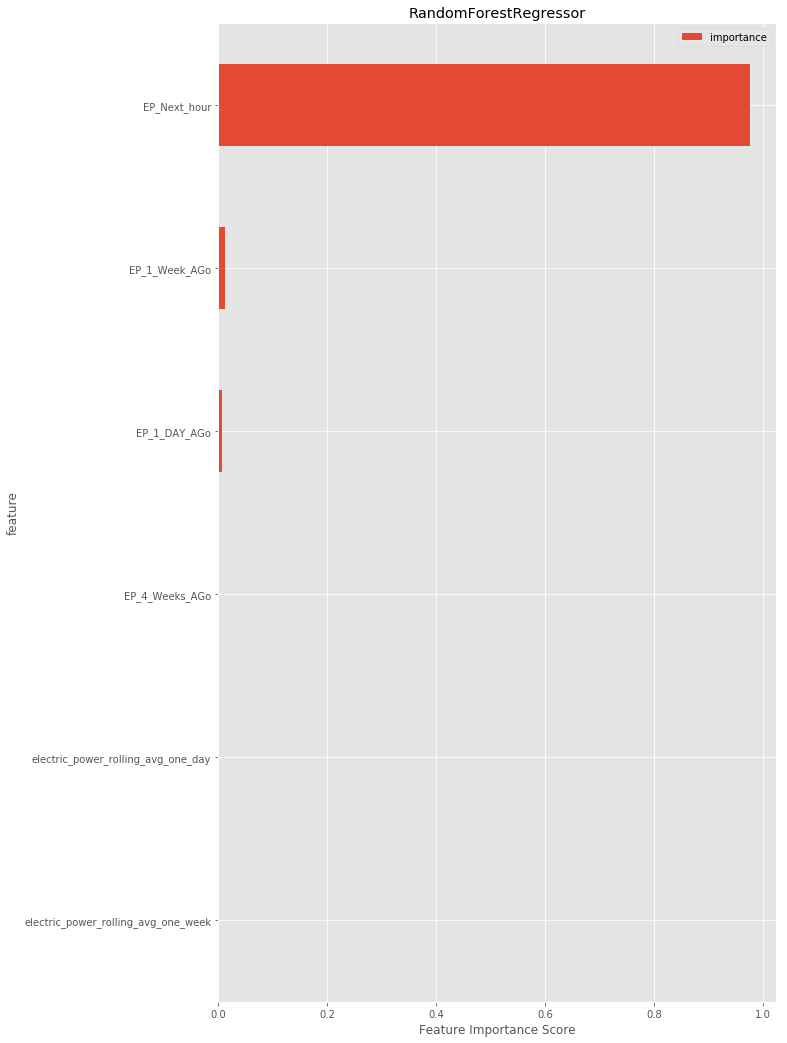

In [44]:
_ = plot_feature_importances(reg, X_train, y_train, top_n=X_train.shape[1], title=reg.__class__.__name__)

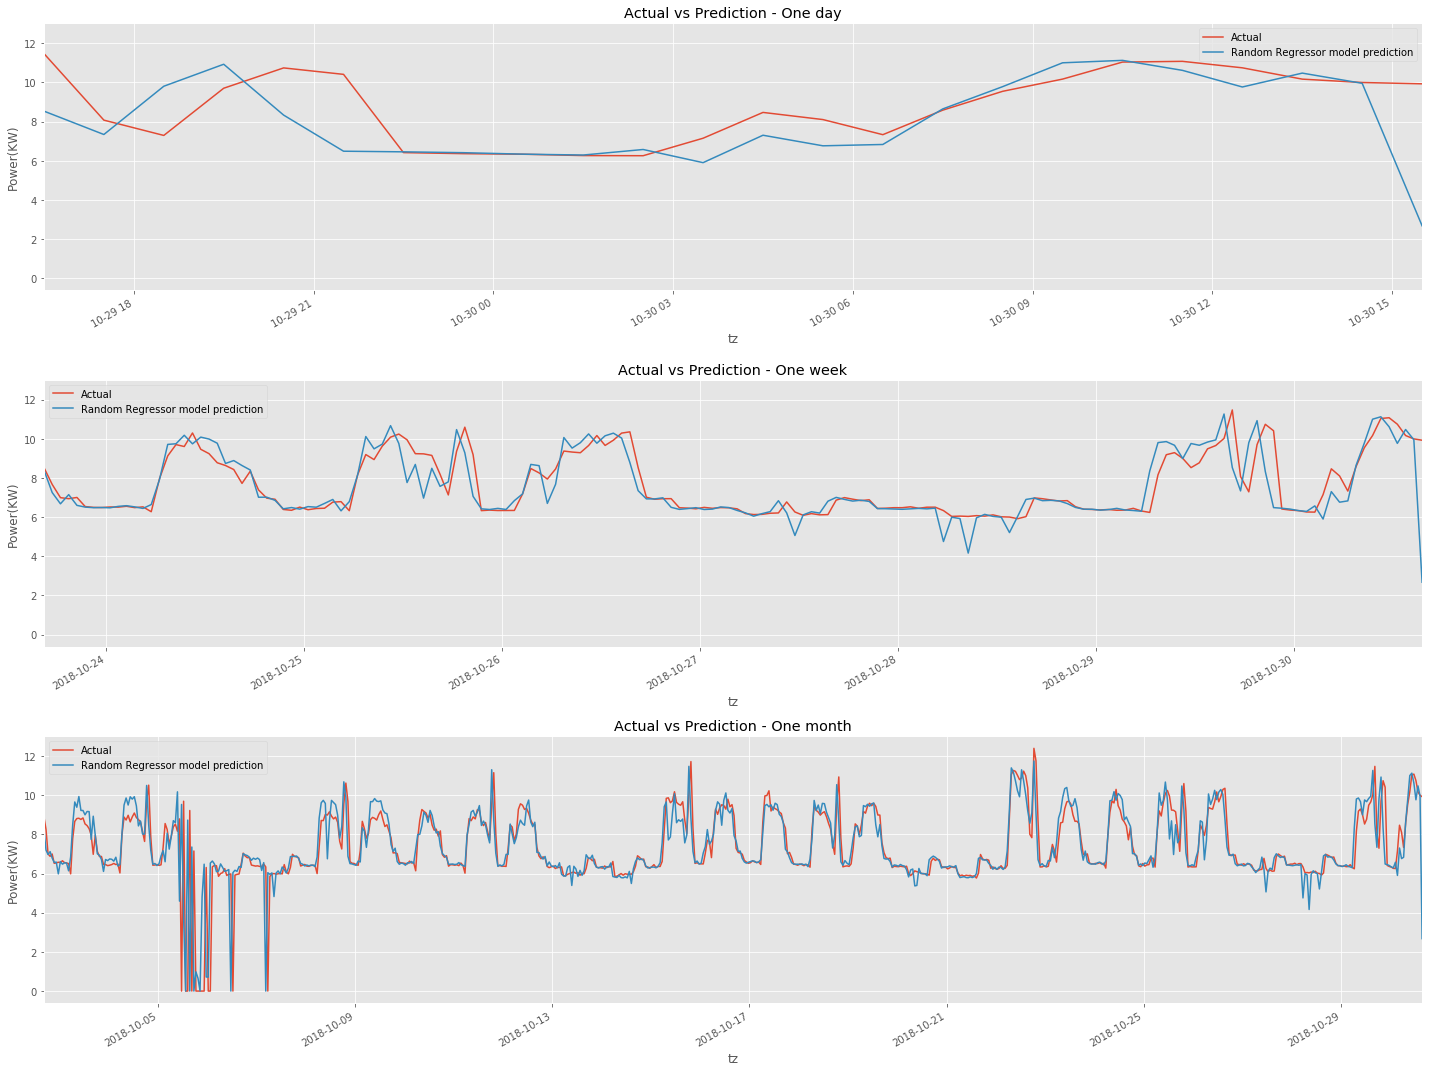

In [45]:
subplot_prediction(y_test, prediction,prediction_label='Random Regressor model prediction')

In [46]:
reg = GradientBoostingRegressor()

In [47]:
tscv = TimeSeriesSplit(n_splits=20)
scores = cross_val_score(reg, X.values, y.values, cv=tscv
                         ,scoring='explained_variance'
                        )
print("Accuracy: %0.2f " % (scores.mean()*100))
print(scores)
reg.fit(X_train,y_train)
prediction = reg.predict(X_test)
print("R2 Score :%0.2f "% r2_score(y_test,prediction))
print(r2_score)

Accuracy: 70.77 
[0.27563097 0.42654107 0.91599242 0.84101678 0.77922307 0.78554681
 0.88025885 0.87536965 0.86605368 0.96163825 0.         0.
 0.9497419  0.91818637 0.8245851  0.82623386 0.82249922 0.75661298
 0.92494645 0.52441923]
R2 Score :0.86 
<function r2_score at 0x000001C530118A60>


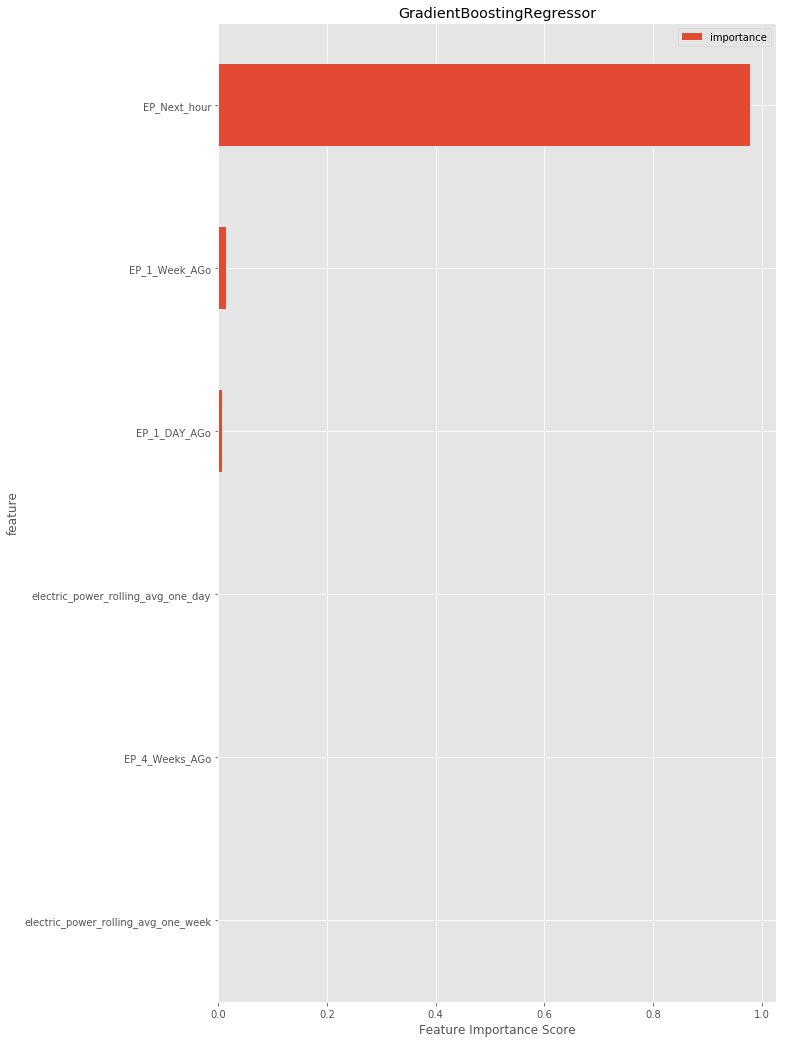

In [48]:
_ = plot_feature_importances(reg, X_train, y_train, top_n=X_train.shape[1], title=reg.__class__.__name__)

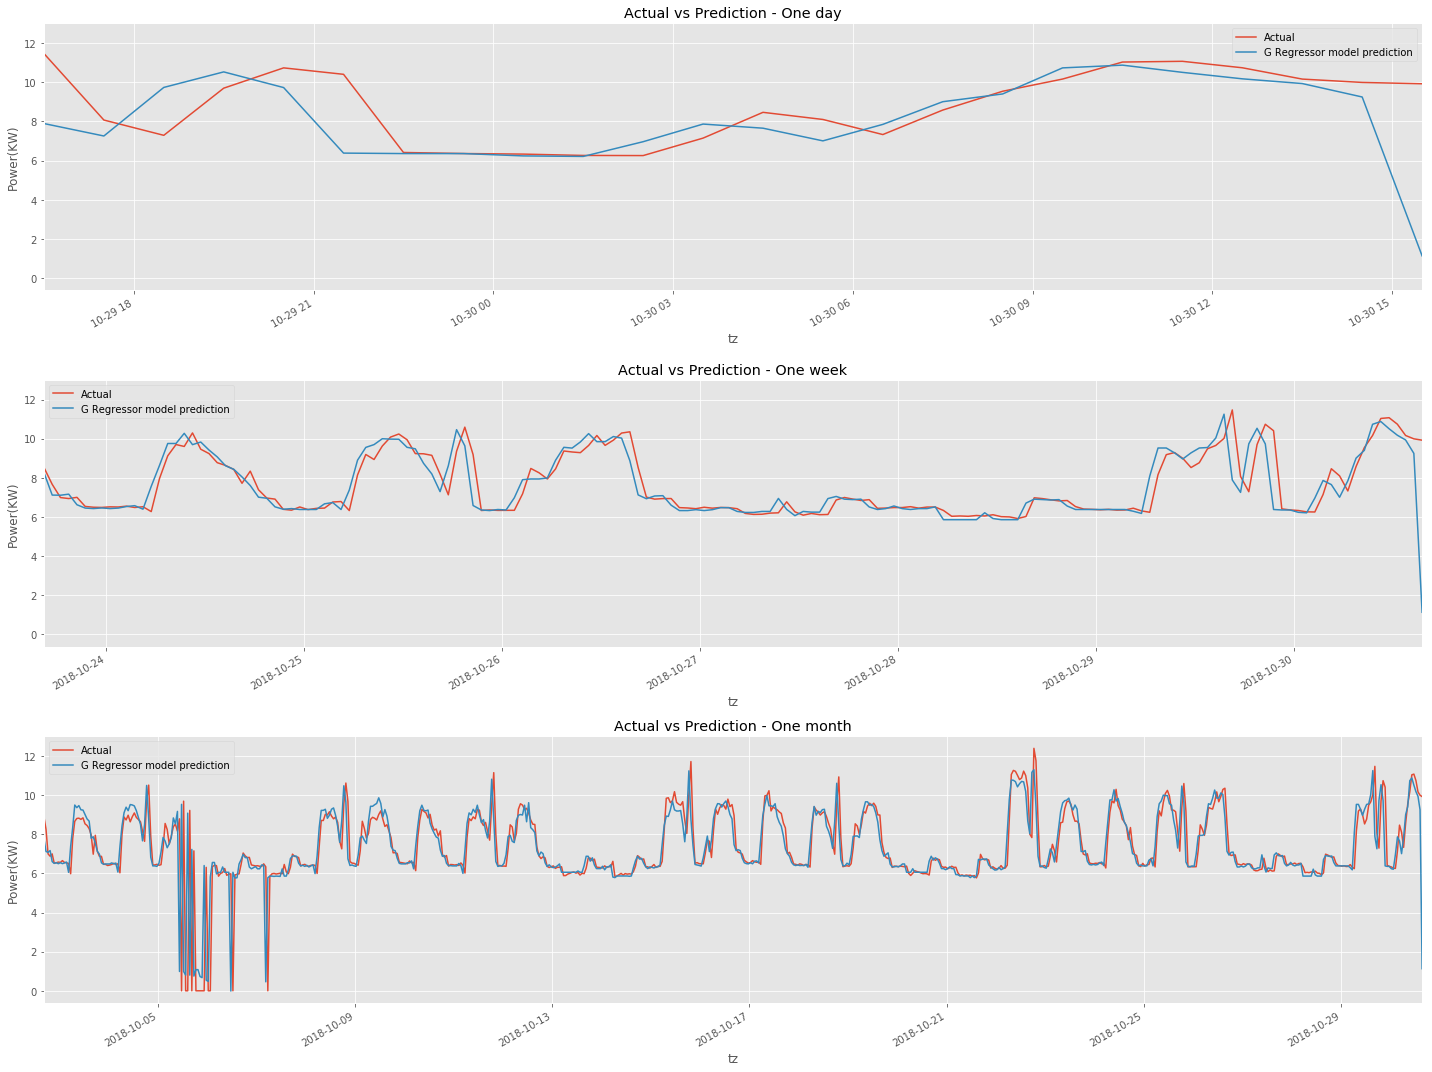

In [49]:
subplot_prediction(y_test, prediction,prediction_label='G Regressor model prediction')